In [29]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from package import coherence_profile as cp
from package import noise_spectra as ns
from scipy.signal import find_peaks

# Coherence Profile, $C_N(t)$, Tutorial

The coherence profile is given by:

$$
C_N(t) = e^{-\frac{1}{\pi} \int _{0}^{\infty} d\omega S(\omega) \frac{F_N(\omega, t)}{\omega^2}}
$$

Where, the filter function, $F_N(\omega,t)$, is defined by the $\pi$ pulse sequence used for dynamical decoupling. 

Frequently, for the purpose of this integration, the filter function is approximated as a $\delta$ function centered at $\omega = \omega_0 =\frac{N\pi}{t}$ (In general, the filter function has peaks near $\frac{N\pi}{t}(2*m + 1), \quad m \in \left[1,2,3,...\right]$, with the first resonance peak being the largest). In this case, the above relationship simplifies to 

$$
C_N(t) = e^{-\frac{t}{\pi}S(\omega_0)} \Rightarrow S(\omega_0) = \frac{-\pi \ln{C(t)}}{t}
$$

The cell below is an example of implementing this approximation to relate $C(t)$ to $S(\omega)$ and visa versa. The function `cp.coherence_decay_profile_delta` implements the $S(\omega) \rightarrow C(t)$ direction, and the function `cp.noise_inversion_delta` implements the reverse direction. You can also see `ns.noise_spectrum_combination` being used below to combine (i.e. sum) different noise profiles together.

1/f 1/e time:  0.6570193735178309
Lorentzian 1/e time:  1.1992253187235848


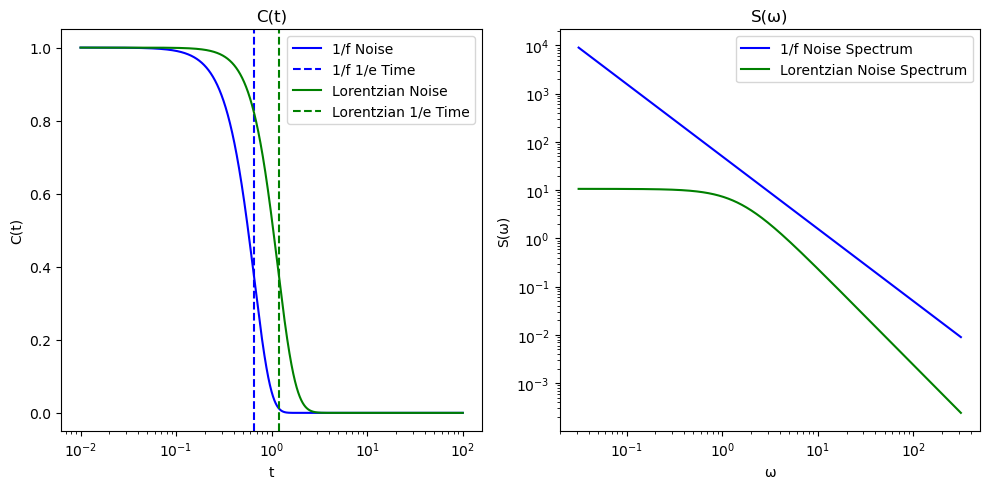

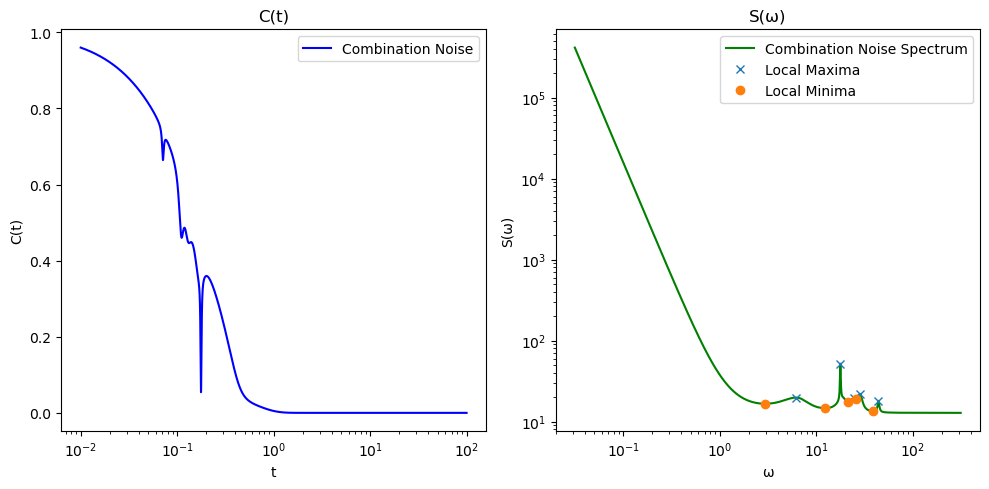

In [30]:
# Example Usage: Coherence Decay Profile Assuming Filter Function is a Delta Function, 1/f Noise, Lorentzian Noise, and combination noise.

t = np.logspace(-2, 2, 10**5) # Time values in microseconds (µs)

s_w_1f = ns.noise_spectrum_1f(np.pi/t, A=50, alpha=1.5)
c_1f = cp.coherence_decay_profile_delta(t, s_w_1f) # Assuming the filter function is a delta function, and given 1/f noise, generate C(t)
c_1f_1e = t[np.argmin(np.abs(np.array(c_1f)-1/np.e))] # Find C(t) 1/e time
print("1/f 1/e time: ", c_1f_1e)
 # same as above, but with a Lorentzian noise profile
s_w_lor = ns.noise_spectrum_lor(np.pi/t, omega_0=0, gamma=1.5, A=50)
c_lor = cp.coherence_decay_profile_delta(t, s_w_lor)
c_lor_1e = t[np.argmin(np.abs(np.array(c_lor)-1/np.e))]
print("Lorentzian 1/e time: ", c_lor_1e)

# Plot comparing the two noise sources respective 

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot y1 in the first subplot
ax1.plot(t,c_1f,label='1/f Noise',color='b')
ax1.axvline(c_1f_1e, color='b', linestyle='--', label='1/f 1/e Time')
ax1.plot(t,c_lor,label='Lorentzian Noise',color='g')
ax1.axvline(c_lor_1e, color='g', linestyle='--', label='Lorentzian 1/e Time')
ax1.set_title("C(t)")
ax1.set_xlabel("t")
ax1.set_ylabel("C(t)")
ax1.set_xscale("log")
ax1.legend()

# Plot y2 in the second subplot
ax2.plot(np.pi/t, s_w_1f, label="1/f Noise Spectrum", color="b")
ax2.plot(np.pi/t, s_w_lor, label="Lorentzian Noise Spectrum", color="g")
ax2.set_title("S(ω)")
ax2.set_xlabel("ω")
ax2.set_ylabel("S(ω)")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend()

# Display the plots
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

#####
# Example with Combined Noise Spectrum, S(ω) = num_1f*<1/f Noise Spectrum> + num_lor*<Lorentzian Noise Spectrum> + num_C*<Constant Noise Spectrum>
#####

num_1f = 1
A_values = np.random.uniform(low=0,high=50,size=num_1f)
alpha_values = np.random.uniform(low=0,high=3,size=num_1f)

num_lor = 7
lor_A_values = np.random.uniform(low=0,high=50,size=num_lor)
omega_0_values = np.random.uniform(low=0,high=50,size=num_lor)
gamma_values = np.random.uniform(low=0,high=3,size=num_lor)

num_C = 1
C_values = np.random.uniform(low=0,high=50,size=num_C)

    
s_w = ns.noise_spectrum_combination(np.pi/t,{'A':A_values,'alpha':alpha_values},{'omega_0':omega_0_values,'gamma':gamma_values,'A':lor_A_values},{"C":C_values},{})
c_t = cp.coherence_decay_profile_delta(t,s_w)

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot y1 in the first subplot
ax1.plot(t, c_t, label="Combination Noise", color="blue")
ax1.set_title("C(t)")
ax1.set_xlabel("t")
ax1.set_ylabel("C(t)")
ax1.set_xscale("log")
ax1.legend()

local_maxima, _ =  find_peaks(s_w)
local_minima, _ = find_peaks(-s_w)

# Plot y2 in the second subplot
ax2.plot(np.pi/t, s_w, label="Combination Noise Spectrum", color="green")
plt.plot((np.pi/t)[local_maxima], s_w[local_maxima], "x", label="Local Maxima")
plt.plot((np.pi/t)[local_minima], s_w[local_minima], "o", label="Local Minima")
ax2.set_title("S(ω)")
ax2.set_xlabel("ω")
ax2.set_ylabel("S(ω)")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend()

# Display the plots
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

# Exact Filter Function

If instead, we use the exact definition of the filter function given by

$$
F_{N}(\omega,t) =\Big|1+(-1)^{N+1}e^{i\omega t}+2\sum_{k=1}^N(-1)^k e^{i\omega t_{k}}\cos\left(\omega \tau_{\pi}/2\right)\Big|^{2}
$$

where $t_k$ is the center of the $k^{th}$ pulse, and $\tau_{\pi}$ is the pulse width, when we compute the integral for C(t), we numerically evaluate the integral via either the Riemann sum method of Trapezoidal or Simpson integration. Aternatively, we allow for `scipy`'s adaptive quadrature, but we don't reccomend it's usage due to the "spikiness" of the integrands and the log spacing we use for our omega ranges.

Below is an example of our implementation of the exact finite-width filter function integral. We parallelize computation over the timepoints in C(t) for faster computation times. However, if you prefer, we also provide a line of code to execute the C(t) computation without CPU parallelization.

CPU times: user 2.5 s, sys: 1.96 s, total: 4.46 s
Wall time: 1min 6s
1/e time:  152.54988821503488


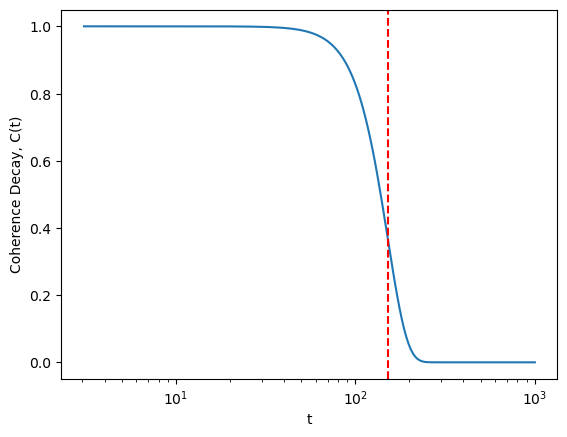

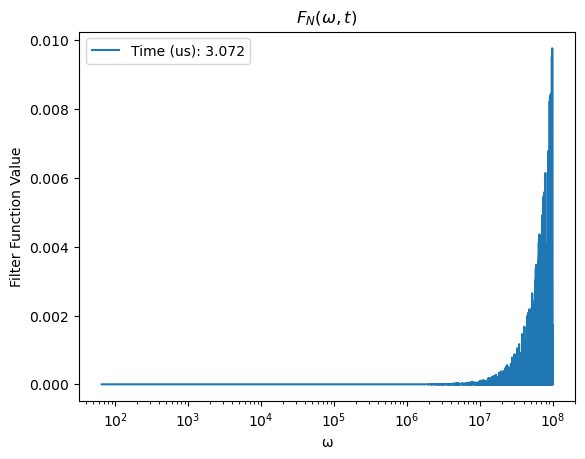

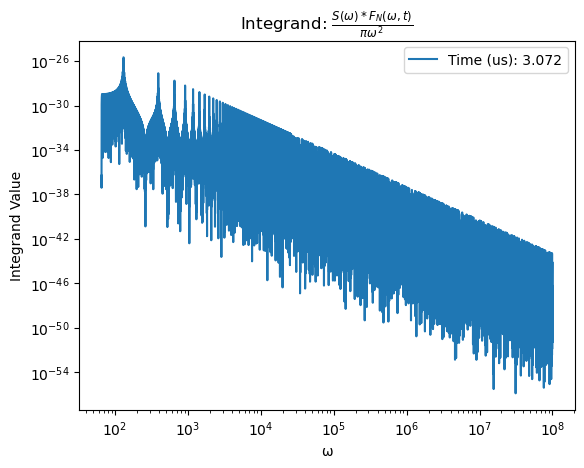

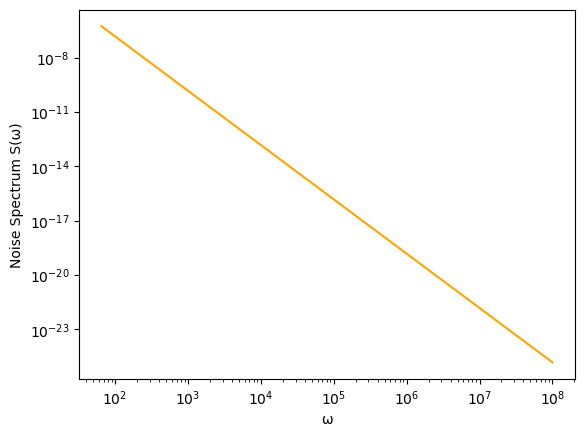

In [36]:
# Example Usage: Compute C(t) for a 1/f noise spectrum with finite pulse widths
tau_p = 0.024
n = 128
# The minimum allowable time is n*tau_p, so we start from there. The +10e-10 is to avoid numererical errors.
times = np.logspace(np.log10(n*tau_p+10e-10,dtype=np.float64), 3, 201, dtype=np.float64)

###
# Set the parameters for integration. See function for more details. In brief:
# "omega_resolution" = The coarse number of points to use for numerical integration. Actual integration uses more points (Approximately O("omega_resolution"+"num_peaks_cutoff"*"peak_resolution"))
# "omega_range" = The minimum and maximum values of omega to consider for integration. If narrow_range = True (default) is passed below, than the range is lower-bounded by (1/2)*(N*π/t), which ignores low-frequency contributions, where the filter function is small.
# "num_peaks_cutoff" = The number of large peaks in the integrand to consider. The larger this is, the more accurate the integral, but the slower the evaluation.
# "peak_resolution" = The number of points to use around each peak in the integrand. This can be useful for improving the accuracy of the integral.
# "quad_limit" = The maximum number of subdivisions in the adaptive quadrature algorithm.
# "epsabs": = Absolute tolerance for the quadrature integration.
# "epsrel": = Relative tolerance for the quadrature integration.

###
integration_params = {
    "omega_resolution": int(10**5), # The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
    "omega_range" : (10**(-4),10**8), # The number of points to use in the filter function
    "num_peaks_cutoff": 100, # must be >=0. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
    "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
    "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
    "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
    "epsrel": 1.49e-8 # Relative tolerance for the quadrature integration
}

integration_method = "trapezoid" # options are "trapezoid", "simpson", and "quad"
noise = ns.noise_spectrum_1f
A = 0.15151515
alpha = 3
args = [A, alpha]

# noise = noise_spectrum_lor
# omega_0 = 1.e+00
# gamma = 1.e-01
# A = 1.e+03
# args = [omega_0, gamma, A]

# Use all available CPUs (default behavior). Change `initial_n_jobs` to alter this.
%time C_t, omega_values_list, filter_values_list, integrand_list = cp.parallel_coherence_decay(times, n, tau_p, integration_method, noise, *args, initial_n_jobs=None, narrow_window = True, max_memory_per_worker=10**4, **integration_params)
# If you dont't want to run this in parallel, you can use:
# %time C_t, omega_values_list, filter_values_list, integrand_list = zip(*[cp.coherence_decay_profile_finite_peaks_with_widths(t, n, tau_p, integration_method, noise, *args, narrow_window = True, **integration_params) for t in tqdm(times)])

###
# Plot the computed Coherence Profile using the exact finite-width pulse sequence
###
print("1/e time: ", times[np.argmin(np.abs(np.array(C_t)-1/np.e))])
plt.plot(times,C_t)
plt.axvline(times[np.argmin(np.abs(np.array(C_t)-1/np.e))], color='r', linestyle='--', label='1/e Time')
plt.xlabel('t')
plt.ylabel('Coherence Decay, C(t)')
# plt.title('Coherence Decay Profile')
plt.xscale('log')
# plt.legend()
plt.show()

###
# Plot the filter function, integrand (i.e. F_n(ω,t)/(π*ω^2)), and noise spectrum for a specific time. (The noise spectrum should be the same across times.)
###
plot_index = 0

plt.plot(omega_values_list[plot_index], filter_values_list[plot_index], label="Time (us): " + "{:.3f}".format(times[plot_index]))
plt.title(r"$F_N(\omega,t)$")
plt.xlabel("ω")
plt.ylabel("Filter Function Value")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

plt.plot(omega_values_list[plot_index], integrand_list[plot_index], label="Time (us): " + "{:.3f}".format(times[plot_index]))
plt.title("Integrand: " + r"$\frac{S(\omega)*F_N(\omega,t)}{\pi\omega^2}$")
plt.xlabel("ω")
plt.ylabel("Integrand Value")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(omega_values_list[plot_index], noise(omega_values_list[plot_index], *args), color="orange", label="Time (us): " + "{:.3f}".format(times[plot_index]))
# plt.title("S(ω)")
plt.xlabel("ω")
plt.ylabel("Noise Spectrum S(ω)")
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.show()

# Fun Aside

If you would like to see how the filter function and the associated integrand, $\frac{S(\omega)*F_N(\omega,t)}{\pi\omega^2}$, change over time, you can run the (commented out) next cell and create a .gif of either of them.

In [ ]:
# import imageio # Make fun gifs to see how the filter function and integrand changes over time
# def create_integrand_gif(omega_values_list, plot_list, times, save_name, n=None, omega_0=None):
#     # Create a figure and axis object
#     fig, ax = plt.subplots(figsize=(8, 6))
#     # Set up the GIF writer
#     writer = imageio.get_writer(save_name, mode='I', duration=0.1)
#     for i in range(len(times)):
#         # Clear the axis
#         ax.clear()
#         # Plot the current integrand
#         ax.plot(omega_values_list[i], plot_list[i], label=f"Time (us): {times[i]:.3f}")
#         if n is not None:
#             peaks = [np.pi*n/times[i] *(2*k+1) for k in range(10)]
#             ax.plot(peaks, [plot_list[i][np.argmin(np.abs(omega_values_list[i]-peak))] for peak in peaks], "x", label="Filter Resonances")
#         if omega_0 is not None:
#             ax.plot(omega_0, plot_list[i][np.argmin(np.abs(omega_values_list[i]-omega_0))], "o", label="Lorentzian Peak")
       
#         if save_name == "integrands_plot.gif":
#             ax.set_title("Integrand: S(w)*F(wt)/(2*Pi*w**2)")
#             ax.set_xlabel("w")
#             ax.set_ylabel("Integrand Value")
#         elif save_name == "filter_functions.gif":
#             ax.set_title("F_n(w,t)")
#             ax.set_xlabel("w")
#             ax.set_ylabel("Filter Function Value")
           
#         ax.set_xscale('log')
#         ax.set_yscale('log')
#         ax.legend()
        
#         # Add the plot to the GIF - UPDATED CODE HERE
#         fig.canvas.draw()
#         # Get the pixel data from the canvas using buffer_rgba instead of tostring_rgb
#         width, height = fig.canvas.get_width_height()
#         # Use buffer_rgba to get the image data
#         buf = fig.canvas.buffer_rgba()
#         # Convert the buffer to an array
#         image = np.frombuffer(buf, dtype=np.uint8).reshape(height, width, 4)
#         # If you need RGB instead of RGBA, you can slice off the alpha channel
#         image = image[:, :, :3]
        
#         writer.append_data(image)
#     # Finish the GIF
#     writer.close()
#     print(f"GIF created: {save_name}")

# create_integrand_gif(omega_values_list, filter_values_list, times, "filter_functions.gif", n=n)
# create_integrand_gif(omega_values_list, integrand_list, times, "integrands_plot.gif", n=n, omega_0=omega_0)